In [1]:
import jwt
import os
from dotenv import load_dotenv
from pathlib import Path
import time
import requests
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
load_dotenv()
currentworkingdir = Path(os.getcwd())
keyspath = currentworkingdir / "keys"

In [3]:
pemfile = os.getenv("demoacct_pem")  

def rsa_private_key():
    """Load and return the pre-generated RSA keys"""
    with open(keyspath / pemfile, "rb") as private_key_file:
        private_key = private_key_file.read()   
        
    return {"private_key": private_key}

In [4]:
# Todo: parameterize query
# https://test-fi1.fisintegrity.com/Treasury/api/json/Reporting.Management/DataEnquiry/GetData/500021361/0/
# Curr%7COneOf%7CAUD%7CCAD%7CGBP%7CUSD/p_FromDate%7CEqualTo%7C2024-08-01/p_ToDate%7CEqualTo%7C2024-08-12/p_OpposingCurr%7CEqualTo%7CUSD/

baseurl = "https://test-fi1.fisintegrity.com/Treasury/api"
file_format = "json"
manager = "Reporting.Management"
app = "DataEnquiry"
method = "GetData"
numbers_datasourceid = "500021361"

url = f"{baseurl}/{file_format}/{manager}/{app}/{method}/{numbers_datasourceid}/0/Curr|OneOf|AUD|CAD|GBP|USD/p_FromDate|EqualTo|2024-07-01/p_ToDate|EqualTo|2024-07-31/p_OpposingCurr|EqualTo|USD/"
audience = url

datasource = os.getenv("demoacct_company")    
user = os.getenv("demoacct_user")
keyid = os.getenv("demoacct_keyid")

def valid_jwt(rsa_private_key):      
    issuer = f'{user}@{datasource}'
    sub = issuer
    algorithm = "RS256"   
    
    token = jwt.encode(
        { # payload
            "sub": sub,
            "aud": audience,
            "iss": issuer,
            #"custom_payload_key": "custom payload value",
            # token generation time
            "nbf": int(time.time()) - 60, 
            "iat": int(time.time()) - 60,
            # expire two minutes into the future
            "exp": int(time.time()) + 120,
        }, 
        rsa_private_key["private_key"],
        algorithm=algorithm,        
        headers={"alg": algorithm, "typ": "JWT", "kid": keyid},
    )

    return token

the_token = valid_jwt(rsa_private_key())

In [5]:
headers = {"Authorization": f"Bearer {the_token}"}
response = requests.get(url, headers=headers)

if response.status_code == 200:
    print('Success!')
elif response.status_code == 404:
    print('Not Found.')

Success!


In [6]:
df = pd.DataFrame(response.json())

df = df.drop(['CashPool', 
              'OpposingCurr', 
              'FromDate', 
              'OpposingFromDate', 
              'DisplayMidRate', 
              'BalanceSeqNo', 
              'RecordTruncated', 
              'Param-Curr', 
              'Param-p_FromDate', 
              'Param-p_ToDate', 
              'Param-p_OpposingCurr'], axis=1)

df[['CalendarDate', 'TheLastOfMonth']] = df[['CalendarDate', 'TheLastOfMonth']].astype('datetime64[ns]')
df[['BankLedgerBal', 'DirectMidRate']] = df[['BankLedgerBal', 'DirectMidRate']].astype('float32')

df.head()

,OurBank,BUnit,Curr,CalendarDate,TheLastOfMonth,BalanceDate,BankLedgerBal,DirectMidRate
0,CITSUBDUSD,SUB D,USD,2024-07-01,2024-07-31,2022-03-31T00:00:00,497185.5,1.000000
1,CITTRSYAUD,TREASURY,AUD,2024-07-01,2024-07-31,2022-03-31T00:00:00,4800580.0,0.708933
2,CITTRSYCAD,TREASURY,CAD,2024-07-01,2024-07-31,2022-09-06T00:00:00,1493778.0,0.787426
3,CITTRSYGBP,TREASURY,GBP,2024-07-01,2024-07-31,2022-09-06T00:00:00,11755161.0,1.350273
4,RBSSUBBGBP,SUB B,GBP,2024-07-01,2024-07-31,2019-06-24T00:00:00,28980000.0,1.350273


In [7]:
df = df.assign(USDEquivalent = (df["BankLedgerBal"] * df["DirectMidRate"]) / 1_000_000)

decimals = 2    
df['USDEquivalent'] = df['USDEquivalent'].apply(lambda x: round(x, decimals))

df.head()

,OurBank,BUnit,Curr,CalendarDate,TheLastOfMonth,BalanceDate,BankLedgerBal,DirectMidRate,USDEquivalent
0,CITSUBDUSD,SUB D,USD,2024-07-01,2024-07-31,2022-03-31T00:00:00,497185.5,1.000000,0.50
1,CITTRSYAUD,TREASURY,AUD,2024-07-01,2024-07-31,2022-03-31T00:00:00,4800580.0,0.708933,3.40
2,CITTRSYCAD,TREASURY,CAD,2024-07-01,2024-07-31,2022-09-06T00:00:00,1493778.0,0.787426,1.18
3,CITTRSYGBP,TREASURY,GBP,2024-07-01,2024-07-31,2022-09-06T00:00:00,11755161.0,1.350273,15.87
4,RBSSUBBGBP,SUB B,GBP,2024-07-01,2024-07-31,2019-06-24T00:00:00,28980000.0,1.350273,39.13


## 

In [8]:
df_balances_pivot = df.pivot_table(index = "CalendarDate", 
                                   columns = "Curr",
                                   values = "USDEquivalent"
                                  )

df_balances_pivot.head(10)

Curr,AUD,CAD,GBP,USD
CalendarDate,,,,
2024-07-01,3.40,1.840000,101.275833,30.337143
2024-07-02,127.96,17.773333,373.723333,160.430000
2024-07-03,134.09,21.350000,573.813333,220.117143
2024-07-04,258.65,37.283333,846.260000,350.210000
2024-07-05,264.78,40.863333,1046.350833,409.898571
2024-07-06,389.34,56.793333,1318.795000,539.990000
2024-07-07,396.14,60.473333,1520.971667,600.665714
2024-07-08,519.34,76.203333,1789.247500,728.781429
2024-07-09,526.83,79.983333,1993.508333,790.445714


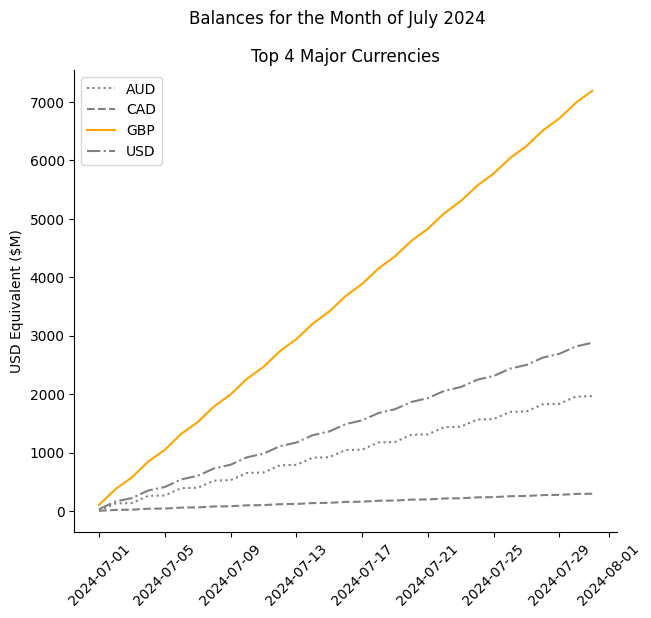

In [13]:
colors=["grey", "grey", "orange", "grey"]
ls=[":", "--", "-", "-."]

fig, ax = plt.subplots(figsize=(7, 6))

for i, column in enumerate(df_balances_pivot.columns):
    ax.plot(
    df_balances_pivot[column],
    color=colors[i],
    ls=ls[i]
    )

fig.suptitle("Balances for the Month of July 2024")
ax.set_title("Top 4 Major Currencies")
ax.set_ylabel("USD Equivalent ($M)")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.legend(df_balances_pivot.columns, loc="upper left")

plt.xticks(rotation=45)

plt.show()